In [1]:
!pip install langchain
!pip install pypdf
!pip install openai
!pip install tiktoken
!pip install anthropic
!pip install fpdf

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains.summarize import load_summarize_chain
from langchain.chat_models import ChatAnthropic
from langchain.schema import Document
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate
import tiktoken

In [4]:
OPENAI_API_KEY = ""
ANTHROPIC_API_KEY = ""

In [2]:
# First loading the file using Pypdf
def loadFile(filename):
    loader = PyPDFLoader(filename)
    return loader.load()

pages = loadFile('/content/crime-and-punishment.pdf')

In [10]:
import matplotlib.pyplot as plt
# Now I'll do some EDA on the book
def plot_chunk_lengths(docs):

  # Now create an array that holds the length of each page
  doc_lengths = list(map(lambda doc:len(doc.page_content),docs))
  plt.hist(doc_lengths, edgecolor='black')

  # Add labels and title
  plt.xlabel('Value')
  plt.ylabel('Frequency')

  # Show the plot
  plt.show()

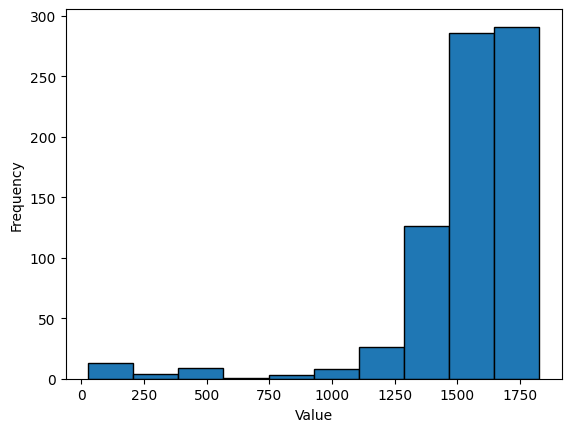

In [11]:
plot_chunk_lengths(pages)

In [104]:
def num_tokens_from_documents(docs, encoding_name = "r50k_base"):
    """Returns the number of tokens from the list of documents."""
    text = combine_docs(docs)
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(text))
    return num_tokens

In [105]:
num_tokens = num_tokens_from_documents(pages)
num_tokens

342235

As there are 342,235 tokens sending all of them to the LLM would be really expensive and time consuming.

In [32]:
# Now lets split the text into multiple documents
def combine_docs(docs):
  text = ""
  for doc in docs:
    text += doc.page_content
  return text

def chunk_documents(text:str, chunk_size: int, overlap: int):
  """Returns the chunked documents from the text"""
  splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = chunk_size,
    chunk_overlap  = overlap,
    separators=["\n\n", "\n", "\t"],
    keep_separator=True)
  return splitter.create_documents([text])

# The chunked text will have 10000 characters each.
chunked_text = chunk_documents(combine_docs(pages),10000,1000)

In [33]:
len(chunked_text)

131

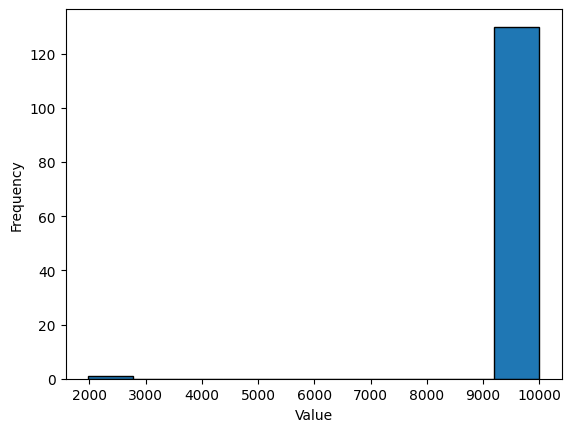

In [34]:
plot_chunk_lengths(chunked_text)

After going through multiple iterations and researching on the internet and some very expensive ($$) attempts to summarize the book using the map_reduce approach mentioned on the langchain docs, I'm now following the clustering approach.

The goal is to reduce the number of tokens being sent to the LLM by creating clusters that revolve around the same topic


In [35]:
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
vectors = embeddings.embed_documents([x.page_content for x in chunked_text])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

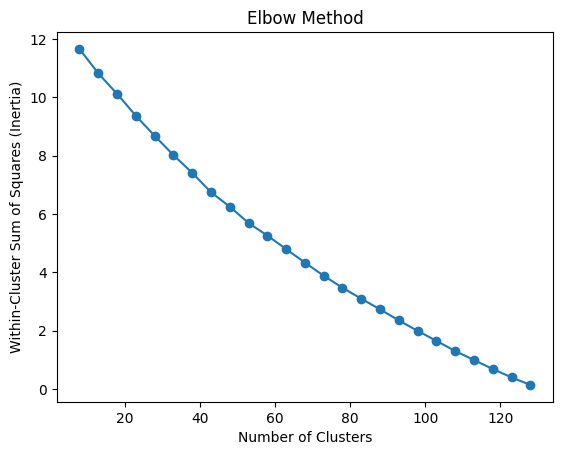

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

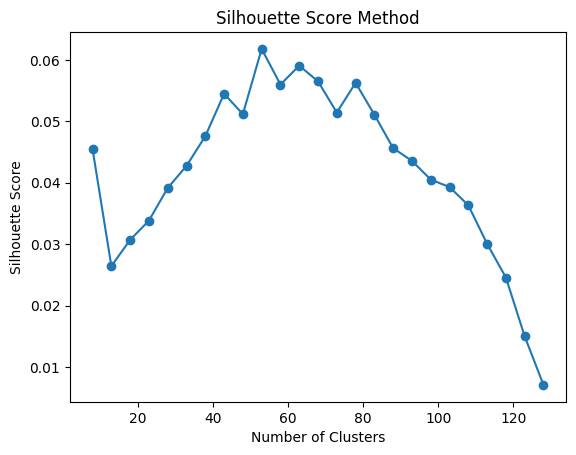

Optimal clusters (Elbow Method): 128
Optimal clusters (Silhouette Score Method): 53


In [37]:
# We will see wether we can redcue the number of tokens being sent to the LLM by creating clusters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np_vectors = np.array(vectors)

# Define a range of possible cluster numbers
possible_clusters = np.arange(8, 130, 5)

# Elbow Method
inertia_values = []

for num_clusters in possible_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(np_vectors)
    inertia_values.append(kmeans.inertia_)

# Plot Elbow Method
plt.plot(possible_clusters, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method')
plt.show()

# Silhouette Score Method
silhouette_scores = []

for num_clusters in possible_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(np_vectors)
    silhouette_scores.append(silhouette_score(np_vectors, kmeans.labels_))

# Plot Silhouette Score Method
plt.plot(possible_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

# Choose the optimal number of clusters based on the analysis
optimal_clusters_elbow = possible_clusters[np.argmin(inertia_values)]
optimal_clusters_silhouette = possible_clusters[np.argmax(silhouette_scores)]

print(f"Optimal clusters (Elbow Method): {optimal_clusters_elbow}")
print(f"Optimal clusters (Silhouette Score Method): {optimal_clusters_silhouette}")


The Silhouette method shows that the best score is achieved with 13 clusters

The Elbow method was not showing any definitive answer so I applied the Silhouette method to extract the optimal number of clusters

In [38]:
num_clusters = 53
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(np_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [39]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(np_vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)


In [40]:
slected_indices = sorted(closest_indices)
selected_docs = [chunked_text[doc] for doc in slected_indices]

In [41]:
# Reducing the number of tokens by removing the '\n' characters since these characters do not convey any meaning
for doc in selected_docs:
  doc.page_content = doc.page_content.replace('\n','')

I'm now following a manual apprach to the langchain map_reduce. I was getting some errros on the context window for the summarizer chain so I decided to use the Anthropic Claude 2.1 model that has 150,000 tokens context window

Using the manual apprach allowed me to use OpenAI for generating the intermediate summaries (It performed the best as comapred to Claude) and using Claude to generate the overall summary of the book



In [70]:

map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should fully encompass what was said in the passage. Create a comprehensive summary in paragraph form
DO NOT CREATE BULLETE POINTS

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [ ]:
llm = ChatOpenAI(api_key=OPENAI_API_KEY)

In [68]:
map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)


In [ ]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])

    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{slected_indices[i]}) - Preview: {chunk_summary[:250]} \n")


In [76]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 20265 tokens


In [91]:
llm2 = ChatAnthropic(anthropic_api_key=ANTHROPIC_API_KEY,max_tokens = 100000)

In [97]:
combine_prompt = """
You are given multiple summaries from a book enclosed in tripple back ticks. The summaries are generated from multiple sections of the book.
Your job now is to write a comprehensive summary of the book after understanding the input text.
The final answer should be a detailed summary of the book and should be detailed. Make it long and detailed.
Use the tone of an experience book reviewer.
```{text}```
SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [98]:
reduce_chain = load_summarize_chain(llm=llm2,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
                              verbose=True # Set this to true if you want to see the inner workings
                                   )

In [99]:
output = reduce_chain.run([summaries])


> Finished chain.

> Finished chain.


In [103]:
# Storing the generate summary in PDF file
from fpdf import FPDF

def create_pdf(my_string, file_path):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", size=11)

    # Split the string into paragraphs
    paragraphs = my_string.split('\n')

    for paragraph in paragraphs:
        pdf.multi_cell(0, 5, paragraph)
        pdf.ln(2)

    # Save the PDF to the specified file path
    pdf.output(file_path)

    print(f"PDF saved to {file_path}")


create_pdf(output,'summary.pdf')

PDF saved to summary.pdf
